<a href="https://colab.research.google.com/github/Tarane2028/ADS-509-Project/blob/main/LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import re

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# 1. Load the provided train.csv (with id and target) and test.csv
train_df = pd.read_csv('/content/drive/MyDrive/ADS509/train (1).csv', usecols=['id', 'text', 'target'])
test_df = pd.read_csv('/content/drive/MyDrive/ADS509/test.csv', usecols=['id','text'])

print(f"Training set: {train_df.shape[0]} tweets (with labels)")
print(f"Test set: {test_df.shape[0]} tweets (no labels)")

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", "", text)    # strip URLs
    text = re.sub(r"@\w+", "", text)                # strip mentions
    text = re.sub(r"#", "", text)                   # drop the hash symbol
    text = re.sub(r"[^a-z0-9\s]", "", text)         # drop punctuation
    text = re.sub(r"\s+", " ", text).strip()        # collapse whitespace
    return text

train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df ['clean_text'] = test_df ['text' ].apply(clean_text)

# 3) Tokenization + stopword removal
def tokenize(text: str):
    # grab only words of length ≥2
    tokens = re.findall(r'\b[a-z]{2,}\b', text)
    # drop English stopwords
    return [t for t in tokens if t not in ENGLISH_STOP_WORDS]

train_df['tokens'] = train_df['clean_text'].apply(tokenize)
test_df ['tokens'] = test_df ['clean_text'] .apply(tokenize)

# 4) Quick sanity check
print(train_df[['id','clean_text','tokens','target']].head().to_string(index=False))

Training set: 7613 tweets (with labels)
Test set: 3263 tweets (no labels)
 id                                                                                                                         clean_text                                                                                               tokens  target
  1                                                               our deeds are the reason of this earthquake may allah forgive us all                                                          [deeds, reason, earthquake, allah, forgive]       1
  4                                                                                              forest fire near la ronge sask canada                                                              [forest, near, la, ronge, sask, canada]       1
  5 all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected [residents, asked, shelter, place, notified, officers, evac

In [ ]:
from collections import Counter
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# ────────────────────────────────────────────────────────────────────────────
# (1) Assume `train_df` is the DataFrame you already have, with these columns:
#      • train_df['tokens']  —  a list of tokens for each tweet
#      • train_df['target']  —  the 0/1 disaster label
# ────────────────────────────────────────────────────────────────────────────

# (2) Corpus‐level stats
total_tweets   = len(train_df)
total_tokens   = sum(len(toklist) for toklist in train_df['tokens'])
vocab_size     = len({t for toklist in train_df['tokens'] for t in toklist})
avg_per_tweet  = total_tokens / total_tweets

stats = pd.DataFrame({
    'Metric': ['Total tweets', 'Total tokens', 'Vocabulary size', 'Avg tokens/tweet'],
    'Value' : [total_tweets,    total_tokens,    vocab_size,        avg_per_tweet]
})
print(stats.to_string(index=False))

# (3) Top 10 unigrams
all_tokens = [t for toklist in train_df['tokens'] for t in toklist]
uni_counts = Counter(all_tokens)
top_unigrams = pd.DataFrame(uni_counts.most_common(10), columns=['Unigram','Count'])
print("\nTop 10 Unigrams:")
print(top_unigrams.to_string(index=False))

# (4) Top 10 bigrams
all_bigrams = []
for toklist in train_df['tokens']:
    all_bigrams += [' '.join((toklist[i], toklist[i+1]))
                     for i in range(len(toklist)-1)]
bi_counts = Counter(all_bigrams)
top_bigrams = pd.DataFrame(bi_counts.most_common(10), columns=['Bigram','Count'])
print("\nTop 10 Bigrams:")
print(top_bigrams.to_string(index=False))

          Metric        Value
    Total tweets  7613.000000
    Total tokens 61134.000000
 Vocabulary size 14218.000000
Avg tokens/tweet     8.030211

Top 10 Unigrams:
  Unigram  Count
     like    345
     just    320
       im    306
      amp    298
      new    226
     dont    208
   people    195
     news    193
    video    165
emergency    157

Top 10 Bigrams:
             Bigram  Count
  burning buildings     59
     suicide bomber     59
        liked video     41
northern california     41
         cross body     39
          oil spill     39
    suicide bombing     34
california wildfire     34
         looks like     33
        mass murder     32


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 1) Prepare X (joined tokens) and y (labels)
X = train_df['tokens'].apply(lambda toks: " ".join(toks))
y = train_df['target']

# 2) Stratified train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# 3) TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

# 4) Train Logistic Regression (balanced classes)
clf = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)
clf.fit(X_train_tfidf, y_train)

# 5) Evaluate
y_pred = clf.predict(X_test_tfidf)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.8245    0.8216    0.8231       869
           1     0.7641    0.7676    0.7658       654

    accuracy                         0.7984      1523
   macro avg     0.7943    0.7946    0.7944      1523
weighted avg     0.7985    0.7984    0.7985      1523


=== Confusion Matrix ===
[[714 155]
 [152 502]]


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 1) Build a document‐term matrix from your tokens
docs       = train_df['tokens'].apply(lambda toks: " ".join(toks))
count_vect = CountVectorizer(max_features=5000, ngram_range=(1,2))
X_counts   = count_vect.fit_transform(docs)

# 2) Fit LDA with 10 topics
n_topics = 10
lda      = LatentDirichletAllocation(n_components=n_topics,
                                     max_iter=10,
                                     random_state=42)
lda.fit(X_counts)

# 3) Print top 10 words for each topic
feature_names = count_vect.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    top_indices = topic.argsort()[:-11:-1]
    top_words   = [feature_names[i] for i in top_indices]
    print(f"Topic {idx:2d}: {', '.join(top_words)}")

# 4) Assign each tweet its “dominant topic”
topic_distr         = lda.transform(X_counts)
train_df['dominant_topic'] = topic_distr.argmax(axis=1)

# 5) Compare topic assignments to true labels
dist = train_df.groupby(['dominant_topic','target']).size().unstack(fill_value=0)
dist['total']       = dist.sum(axis=1)
dist['pct_disaster']= dist[1] / dist['total']

print("\nTopic vs. Label Distribution:")
print(dist)

Topic  0: video, amp, liked, loud, liked video, failure, sandstorm, structural, watch, bang
Topic  1: amp, like, body, new, cross, rt, saudi, train, bag, look
Topic  2: im, bomb, nuclear, old, just, california, fear, school, right, suicide
Topic  3: buildings, emergency, burning, burning buildings, food, black, plan, lives, movie, set
Topic  4: just, like, fires, know, love, new, think, looks, im, dont
Topic  5: police, hiroshima, oil, malaysia, pm, spill, oil spill, news, attack, wreckage
Topic  6: wildfire, california, latest, thunderstorm, homes, warning, news, severe, emergency, flames
Topic  7: im, got, like, forest, wreck, fall, bombing, boy, make, suicide
Topic  8: families, legionnaires, disaster, army, outbreak, natural, killed, people, fatal, affected
Topic  9: dont, disaster, like, obama, body, mass, live, reddit, really, twister

Topic vs. Label Distribution:
target            0    1  total  pct_disaster
dominant_topic                               
0               335  287

In [ ]:
!pip install pyLDAvis

In [ ]:
!pip install gensim


LDA Topics (Top 10 words each):
Topic 0: video, amp, liked, loud, liked video, failure, sandstorm, structural, watch, bang
Topic 1: amp, like, body, new, cross, rt, saudi, train, bag, look
Topic 2: im, bomb, nuclear, old, just, california, fear, school, right, suicide
Topic 3: buildings, emergency, burning, burning buildings, food, black, plan, lives, movie, set
Topic 4: just, like, fires, know, love, new, think, looks, im, dont
Topic 5: police, hiroshima, oil, malaysia, pm, spill, oil spill, news, attack, wreckage
Topic 6: wildfire, california, latest, thunderstorm, homes, warning, news, severe, emergency, flames
Topic 7: im, got, like, forest, wreck, fall, bombing, boy, make, suicide
Topic 8: families, legionnaires, disaster, army, outbreak, natural, killed, people, fatal, affected
Topic 9: dont, disaster, like, obama, body, mass, live, reddit, really, twister

Topic vs. Label Distribution:
target            0    1  total  pct_disaster
dominant_topic                               
0

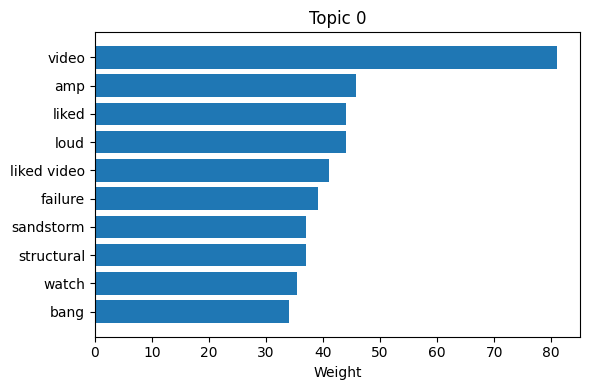

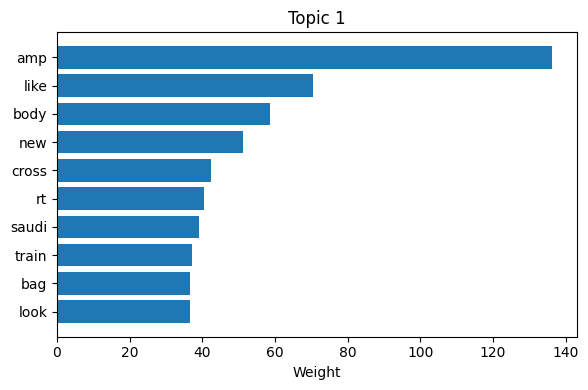

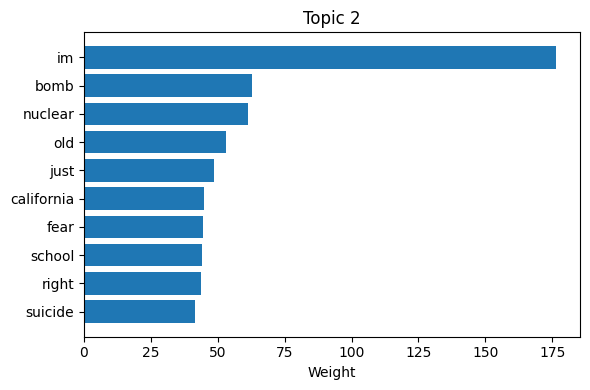

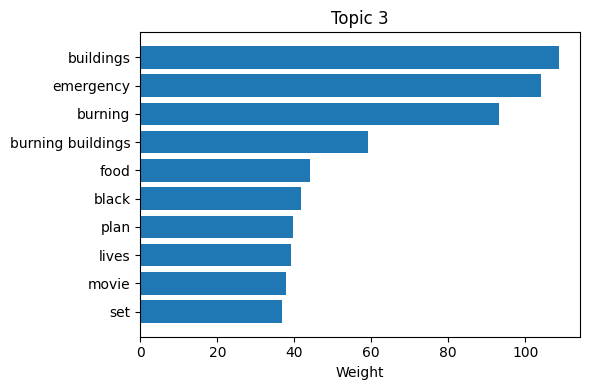

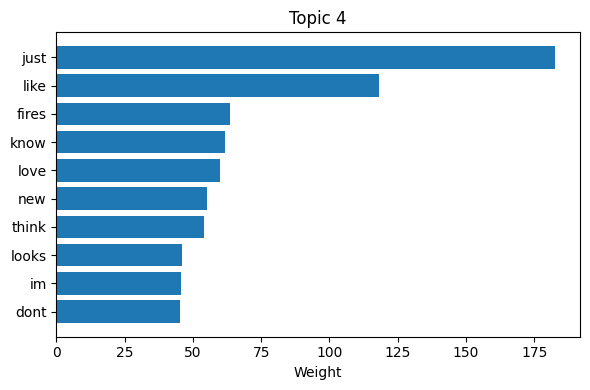

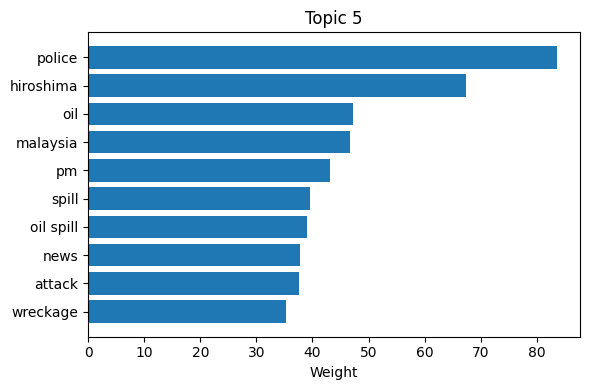

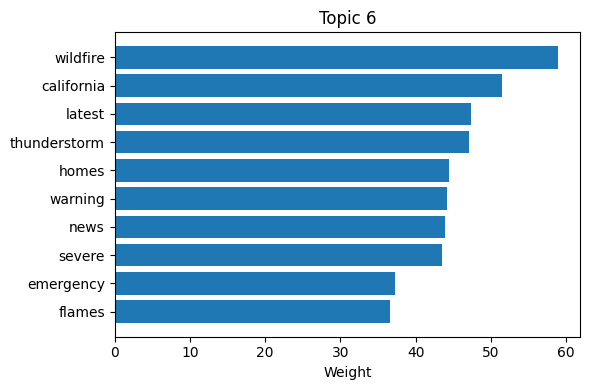

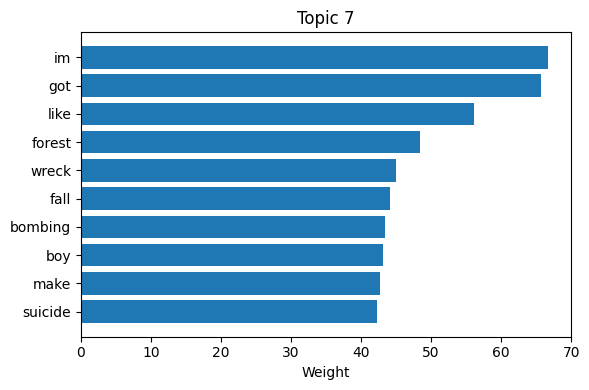

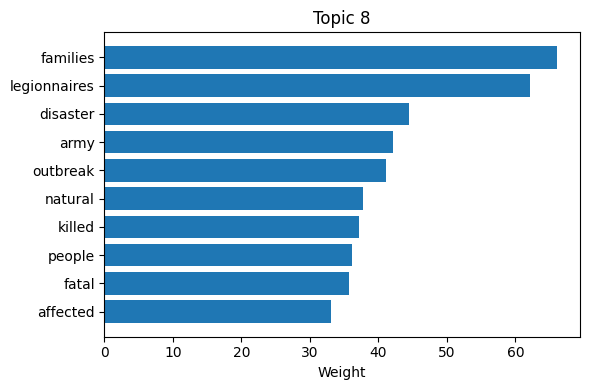

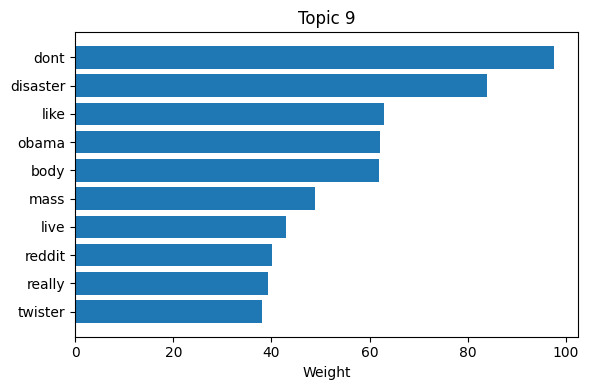

In [ ]:
# 1) Imports
import pandas as pd
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

# 2) Load your train.csv (with id, text, target)
TRAIN_PATH = '/content/drive/MyDrive/ADS509/train (1).csv'   # ← update this to the correct path on your system
df = pd.read_csv(TRAIN_PATH, usecols=['id','text','target'])

# 3) Clean function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return re.sub(r"\s+", " ", text).strip()

df['clean_text'] = df['text'].apply(clean_text)

# 4) Tokenization (dropping English stopwords)
def tokenize(text):
    tokens = re.findall(r'\b[a-z]{2,}\b', text)
    return [t for t in tokens if t not in ENGLISH_STOP_WORDS]

df['tokens'] = df['clean_text'].apply(tokenize)

# 5) Build the document-term matrix (unigrams + bigrams)
docs = df['tokens'].apply(lambda toks: " ".join(toks))
vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,2))
X_counts = vectorizer.fit_transform(docs)

# 6) Fit LDA with 10 topics
lda = LatentDirichletAllocation(n_components=10, max_iter=10, random_state=42)
lda.fit(X_counts)

# 7) Print out the top 10 words per topic
feature_names = vectorizer.get_feature_names_out()
print("\nLDA Topics (Top 10 words each):")
for idx, comp in enumerate(lda.components_):
    top_idxs  = comp.argsort()[:-11:-1]
    top_words = [feature_names[i] for i in top_idxs]
    print(f"Topic {idx}: {', '.join(top_words)}")

# 8) Assign dominant topic to each tweet
topic_distr            = lda.transform(X_counts)
df['dominant_topic']  = topic_distr.argmax(axis=1)

# 9) Compute Topic vs. Label distribution
dist = df.groupby(['dominant_topic','target']) \
         .size().unstack(fill_value=0)
dist['total']        = dist.sum(axis=1)
dist['pct_disaster'] = dist[1] / dist['total']
print("\nTopic vs. Label Distribution:")
print(dist)

# 10) Plot bar charts for each topic
for idx, comp in enumerate(lda.components_):
    top_idxs  = comp.argsort()[:-11:-1]
    top_words = [feature_names[i] for i in top_idxs]
    top_vals  = comp[top_idxs]

    plt.figure(figsize=(6,4))
    plt.barh(top_words[::-1], top_vals[::-1])
    plt.title(f"Topic {idx}")
    plt.xlabel("Weight")
    plt.tight_layout()
    plt.show()